# Разработка стратегии взаимодействия с пользователями сети фитнес-центров

Данный проект подготовлен для сети фитнес-центров «Культурист-датасаентист» с целью разработки стратегии взаимодействия с клиентами на основе аналитических данных. 
Основной запрос фитнес-центра: подготовка плана действий по удержанию клиентов и определение причин их оттока. Данные предоставлены отделом по работе с клиентамив виде клиентских анкет за последний месяц. 

**Цель исследования:** разработка стратегии взаимодействия и удержания клиентов сети фитнес-центров.


**Задачи исследования:**
* спрогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
* сформировать типичные портреты пользователей;
* проанализировать основные признаки, наиболее сильно влияющие на отток;
* сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами.

**План работы:**
* подготовка данных;
* EDA;
* выбор условий экспериментов машинного обучения;
* обучение модели бинарной классификации;
* обучение модели кластеризации;
* обработка результатов.

**Описание данных:**
- `'Churn'` — факт оттока в текущем месяце;
- `'gender'` — пол
- `'Near_Location'` — проживание или работа в районе, где находится фитнес-центр
- `'Partner'` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента)
- `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)
- `'Phone'` — наличие контактного телефона
- `'Age'` — возраст
- `'Lifetime'` — время с момента первого обращения в фитнес-центр (в месяцах)

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента
- `'Contract_period'` — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)
- `'Month_to_end_contract'` — срок до окончания текущего действующего абонемента (в месяцах)
- `'Group_visits'` — факт посещения групповых занятий
- `'Avg_class_frequency_total'` — средняя частота посещений в неделю за все время с начала действия абонемента
- `'Avg_class_frequency_current_month'` — средняя частота посещений в неделю за предыдущий месяц
- `'Avg_additional_charges_total'` — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон

## Подготовка данных

In [1]:
import pandas as pd  # импорт библиотек
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, silhouette_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage 

In [2]:
data = pd.read_csv('datasets\\gym_churn.csv') # открытие и чтение файла
data.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [3]:
data.info() # общая информация 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [4]:
data.duplicated().sum() # проверка на дубликаты

0

Всего представлено 4000 анкет, пропусков нет, дубликатов тоже, присутствуют категориальные переменные (в числовом формате) и количественные. Стоит изучить распределение этих переменных и составить примерное распределение их влияния на целевую величину - факт оттока клиента.

## Исследовательский анализ данных (EDA)

In [5]:
data.columns = [i.lower() for i in data.columns] # переименуем столбцы

In [6]:
data.describe() # посмотрим на распределение значений

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


Итак, как мы уже выяснили, пропусков в датасете нет, что немного облегчает задачу. Во многих признаках есть всего два значения т.е. в столбце "gender"  1 - это мужской пол и 0, соответственно, женский (точной информации об этом распределении нет), поэтому нули в таких столбцах нельзя считать за пропуски. К таким переменным относятся пол клиента, проживание в районе фитнес-клуба (да/нет), участие в промо-акции или партнерство, наличие телефона, посещение групповых занятий, и, разумеется, факт оттока в текущем месяце.

Возраст пользователей распределен нормально на первый взгляд, максимальный лайфтайм клиентов 31 месяц, минимальный 0 (это, видимо, новые посетители). Интересны показатели со средней посещаемостью и средней выручкой помимо посещения самого фитнес-зала, кажется, что они могут проявить корреляцию с нашей целевой переменной.

Если судить по полученным показателям, типичный клиент фитнес-клуба скорее всего живет или работает рядом в компании-партнере с центром и ему около 29 лет, в анкете есть данные его номера телефона, а срок абонемента в среднем составляет 5 месяцев. Такой клиент посещает фитнес-клуб один-два раза в неделю.

Сравним характеристики анкет пользователей по факту оттока.

In [7]:
print(data['churn'].value_counts()) # распределение по количеству
data.groupby('churn').mean().T # средние значения показателей у двух групп клиентов

0    2939
1    1061
Name: churn, dtype: int64


churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


Действительно, заметные различия наблюдаются у признаков среднего посещения и выручки (у активных клиентов эти показатели выше). Так же у них чаще наблюдается использование промо-акции "Приведи друга" или партнерство фирмы-работодателя и фитнес-клуба. У клиентов в оттоке меньше лайфтайм и срок контракта.

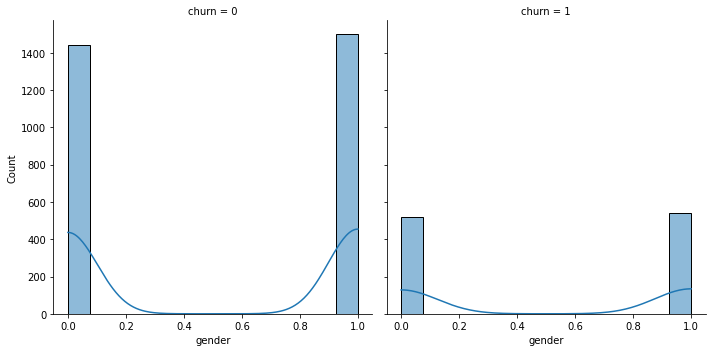

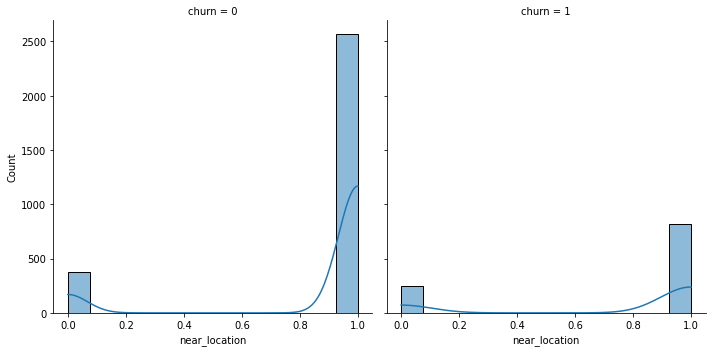

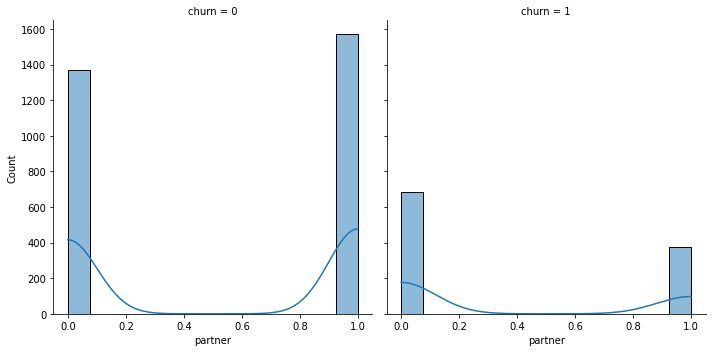

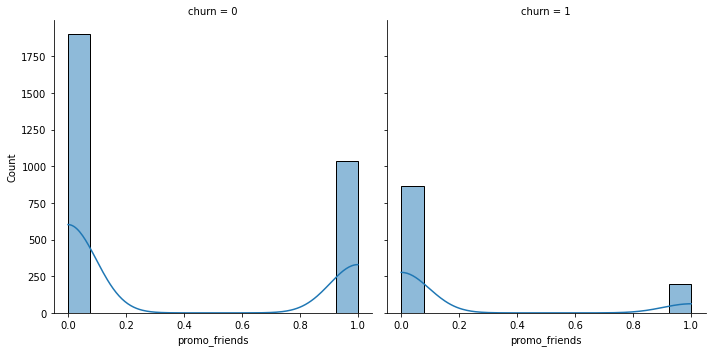

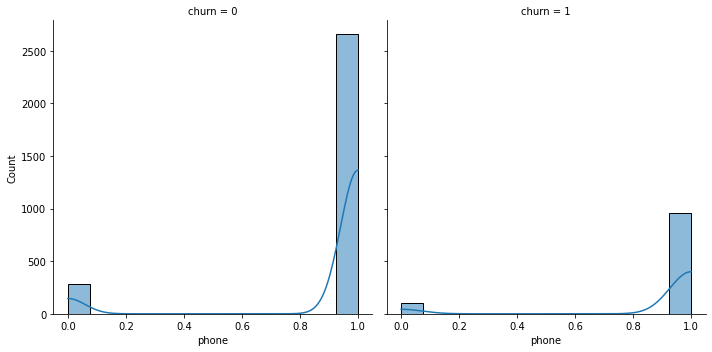

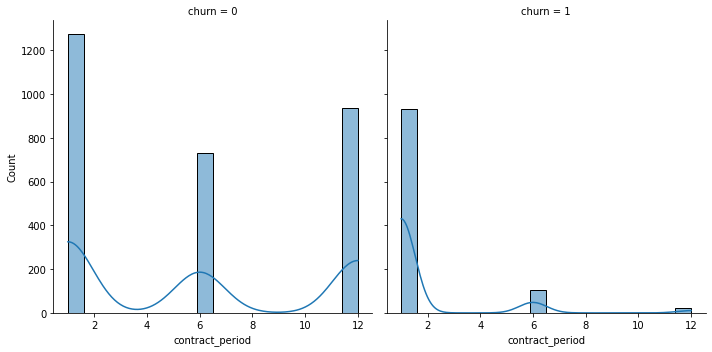

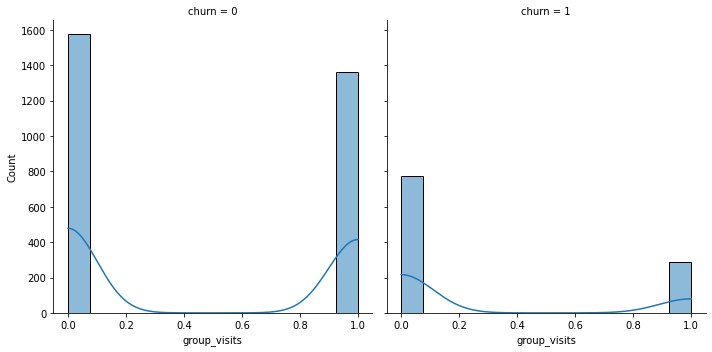

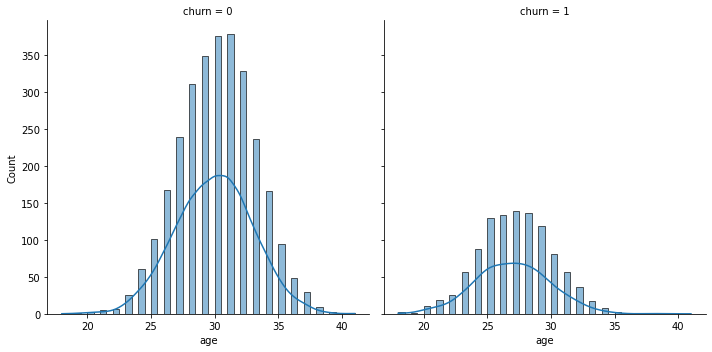

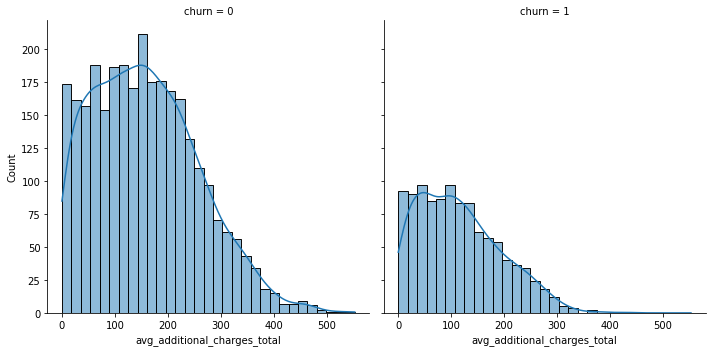

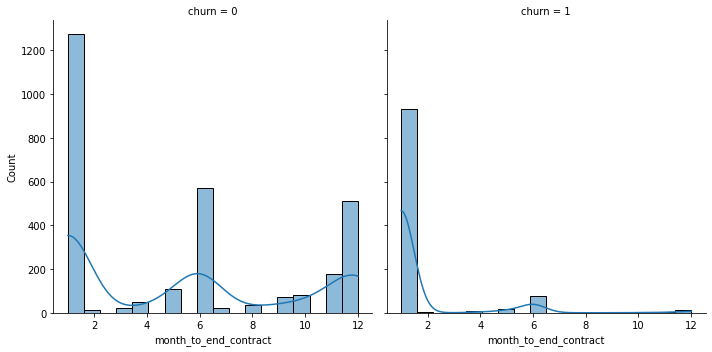

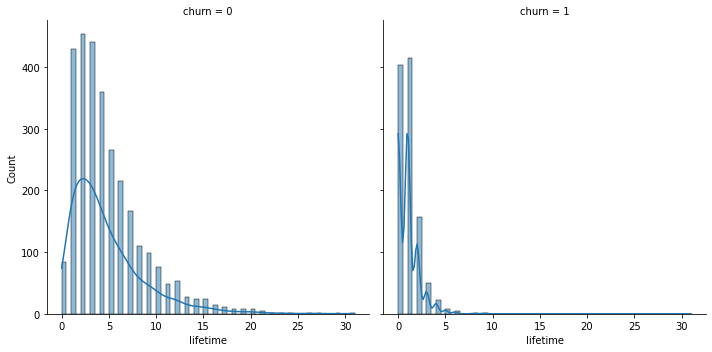

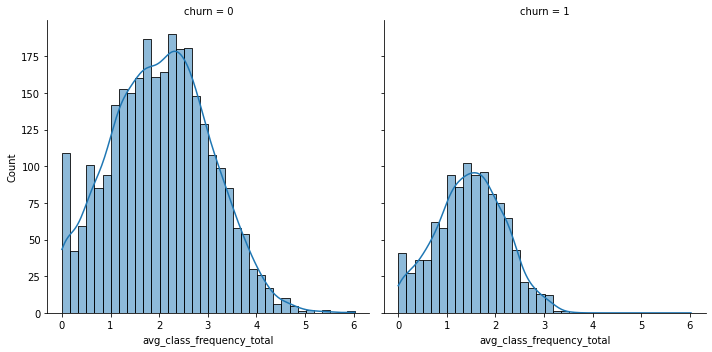

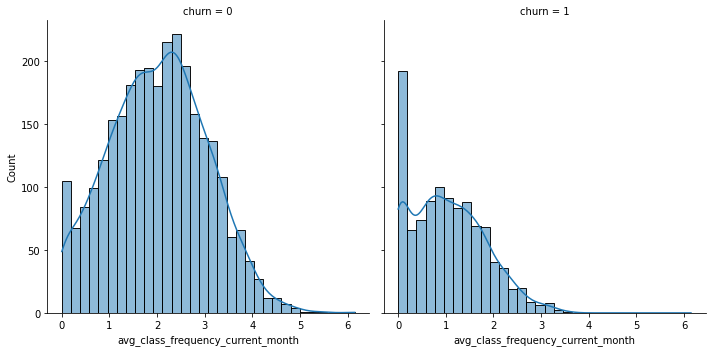

In [8]:
for column in data.drop('churn', axis=1).columns: # распределение признаков
    sns.displot(data=data, x=column, kde=True, col='churn')
    plt.show()

Графики примерно соответствуют ожиданиям, активные пользователи гораздо чаще берут длительный абонемент, приходят на групповые занятия и являются сотрудниками компаний-партнеров, а значит, имеют скидки на абонемент. А еще большая их часть оставляет свой номер телефона.

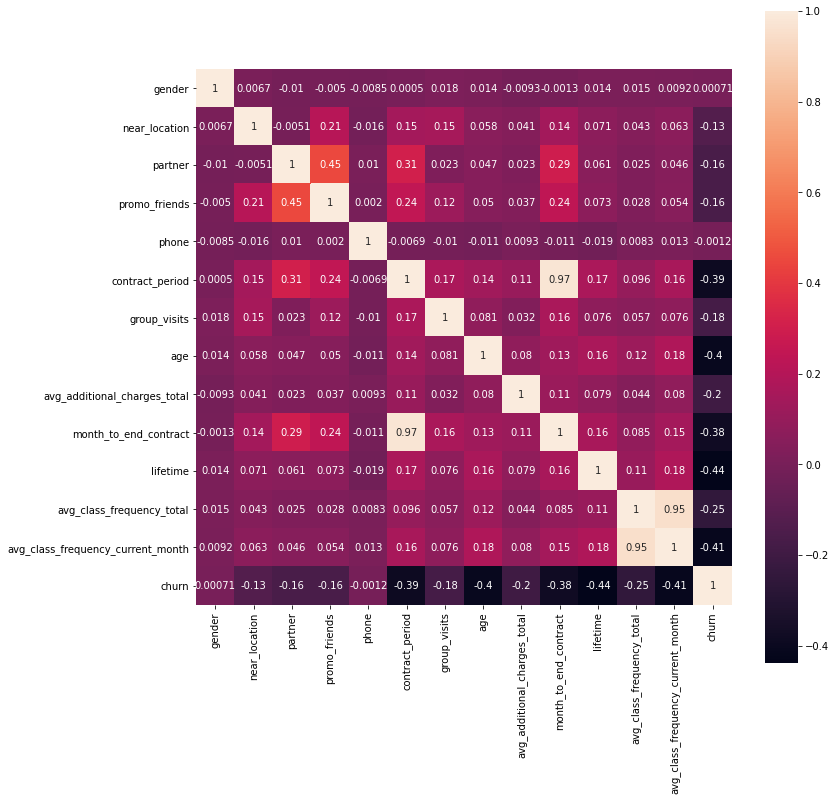

In [9]:
# матрица корреляции

x_corr = data.corr() 


fig, ax = plt.subplots(figsize=(12,12)) # тепловая карта матрицы корреляции
sns.heatmap(x_corr, annot=True, square=True) 
plt.show()

Среди признаков затесались мультиколлинеарные: это длительность текущего абонемента и срок его окончания, а еще средняя частота посещения в неделю за прошлый месяц и за весь период ранее. Наблюдается средняя корреляционная связь между двумя промо-предложениями: акция за друга и партнерство с фитнес-клубом.

По отношению к ключевой переменной отрицательную корреляционную связь проявляют признаки средней частоты посещений, длительность лайфтайма и срок окончания контракта, длительность контракта и, неожиданно, возраст.

От мультиколлинеарных признаков избавимся при выделении матрицы для обучения модели.

**Итак,** что мы сделали в этом блоке: проанализировали признаки, проверили их распределение и сделали предположения об их влиянии на отток клиентов. В этот раз пропуски и категориальные переменные в датасете отсутствовали, что не потребовало дополнительной предобработки. 

## Модель прогнозирования оттока пользователей

Прежде чем обучать модель и делать прогнозы, стоит определиться с условиями эксперимента.

* Разбивка выборки на тестовую и валидационную будет производиться без привязки к временному периоду, то есть стандартно методом train_test_split, размеры выборок 80/20.
* В случае прогнозирования оттока пользователей мы имеем дело с классической задачей бинарной классификации. В качестве модели машинного обучения можно использовать простой алгоритм логистической регрессии и алгоритм посложнее, например, случайный лес. Стоит провести различные расчеты и сравнить результаты моделей между собой, чтобы выбрать лучший вариант.
* В качестве метрик для оценки наших моделей попробуем сравнить показатели Accuracy, Recall, Precision и F1-score.
   * Первый показатель доли правильных ответов будет не совсем корректным, так как распределение клиентов по признаку оттока в датасете неравномерно, 26,5% клиентов "в оттоке", значит, уже можно прогнозировать оценку точности минимум в 70%.
   * Более интересны показатели точности и полноты, однако, чтобы решить, на какую именно из метрик ориентироваться, нужно примерно понимать, готова ли компания вкладывать ресурсы в сохранение клиента. Если да, то приоритетом будет точность модели.

In [10]:
# формируем матрицу признаков и целевую переменную
X = data.drop(columns=['churn', 'avg_class_frequency_current_month', 'month_to_end_contract'])
y = data['churn']

# делим выборку на обучающую и валидационную
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# стандартизация
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

In [11]:
def metrics(model, y_test, y_predict):
    print(f'Расчет метрик для модели {model}:')
    print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_predict)))
    print('Precision: {:.2f}'.format(precision_score(y_test, y_predict)))
    print('Recall: {:.2f}'.format(recall_score(y_test, y_predict)))
    print('F1: {:.2f}'.format(f1_score(y_test, y_predict)))

In [12]:
lr_model = LogisticRegression(solver='liblinear') # логистическая регрессия

lr_model.fit(X_train_st, y_train)

lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:,1]

In [13]:
metrics('Logistic Regression', y_test, lr_predictions) #  метрики для логистической регрессии

Расчет метрик для модели Logistic Regression:
Accuracy: 0.91
Precision: 0.83
Recall: 0.83
F1: 0.83


In [14]:
f_model = RandomForestClassifier(n_estimators=100)  # случайный лес

f_model.fit(X_train_st, y_train)

f_predictions = f_model.predict(X_test_st)
f_probabilities = f_model.predict_proba(X_test_st)[:,1]

In [15]:
metrics('Random Forest Classifier', y_test, f_predictions) # метрики случайного леса

Расчет метрик для модели Random Forest Classifier:
Accuracy: 0.90
Precision: 0.82
Recall: 0.79
F1: 0.80


Результаты выходят такими, что лучше оказывается модель логистической регрессии, у нее выше метрики полноты и f1-score, хотя случайный лес и отстает совсем немного. 

## Модель кластеризации пользователей

Возможно, если всех наших клиентов можно распределить на блоки по определенным характеристикам, мы обнаружим группу с признаками, характерными для клиентов в оттоке. Сегментация клиентов - один из частых случаев кластеризации. 

В качестве модели машинного обучения попробуем применить K-means, но прежде построим дендрограмму датасета и оценим предложенное число кластеров.
Для оценки качества модели будем использовать метрику силуэта.

In [16]:
sc = StandardScaler()  # стандартизация
X_st = sc.fit_transform(X)

In [17]:
linked = linkage(X_st, method = 'ward') # матрица расстояний

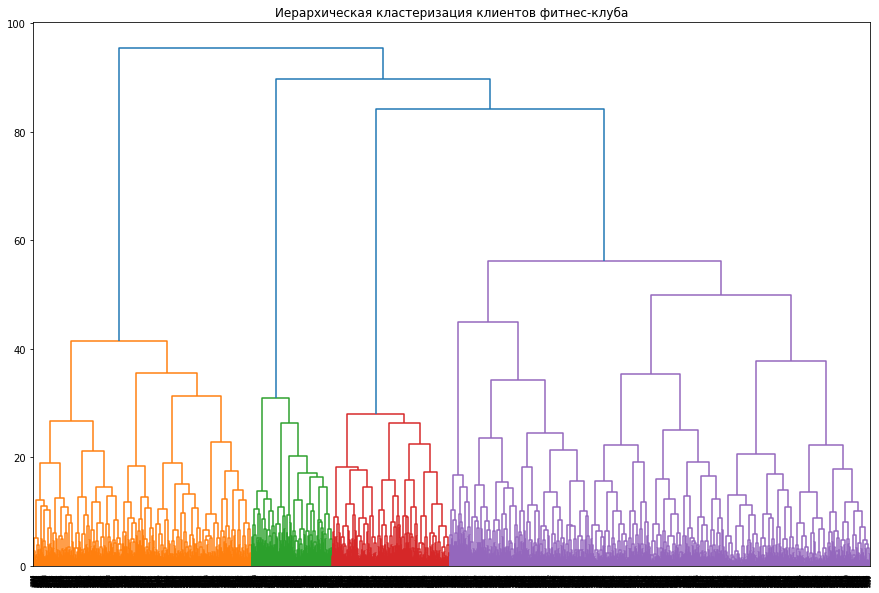

In [18]:
plt.figure(figsize=(15, 10))   # дендрограмма
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация клиентов фитнес-клуба')
plt.show() 

Дендрограмма предлагает разделить клиентов на четыре кластера, причем последний по размеру больше всех остальных вместе взятых. Для модели K-means попробуем взять 5 кластеров.

In [19]:
# модель K-means на 5 кластеров
km = KMeans(n_clusters=5, random_state=0)

# прогнозируем кластеры
labels = km.fit_predict(X_st)

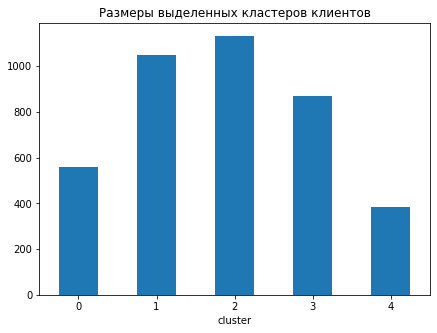

In [33]:
# добавляем метки кластера в датасет
data['cluster'] = labels

# размеры полученных кластеров
plt.figure(figsize=(7,5))
data.groupby('cluster')['gender'].count().plot(kind='bar')
plt.title('Размеры выделенных кластеров клиентов')
plt.tick_params(axis='x', labelrotation = 0)
plt.show()

In [21]:
# выводим статистику по средним значениям наших признаков по кластеру
data.groupby('cluster').mean().T

cluster,0,1,2,3,4
gender,0.499109,0.488571,0.505300,0.544202,0.523316
near_location,0.000000,0.995238,1.000000,1.000000,0.862694
partner,0.488414,0.955238,0.238516,0.250287,0.471503
promo_friends,0.076649,0.892381,0.059187,0.079219,0.305699
phone,1.000000,1.000000,1.000000,1.000000,0.000000
contract_period,3.032086,7.660952,2.819788,4.528129,4.777202
group_visits,0.235294,0.458095,0.000000,1.000000,0.427461
age,28.721925,29.543810,28.770318,29.536165,29.297927
avg_additional_charges_total,137.540009,155.861428,143.383993,148.088897,144.208179
month_to_end_contract,2.853832,6.988571,2.650177,4.165327,4.466321


В качестве описания кластеров я буду их называть в порядке от 1 до 5. Так вот сразу бросается в глаза контраст значения churn: в среднем группа 3 и 4 имеют почти 50% клиентов "в оттоке", тогда как у других групп это значение ниже 7%. Самый лояльный кластер по числу активных клиентов это первый. Попробуем кратко описать характерные черты каждого кластера:


1. Живет или работает далеко от центра; 50/50 работает у компании-партнера, промо-акцией друга не пользуется; оставлял номер телефона; абонемент куплен на три месяца; не посещает групповые занятия, самая низкая дополнительная выручка, **средняя доля оттока 39,9%**


2. Живет или работает поблизости, участвует в программе партнерства и промо-акции, оставлял номер телефона, абонемент на полгода и выше, обычно посещает групповые занятия, самая высокая дополнительная выручка, посещает центр стабильно два раза в неделю, **средняя доля оттока 12,1%**.


3. Живет или работает поблизости, не пользовался промо-акцией, оставлял номер телефона, самый короткий период абонемента, средняя дополнительная выручка, не посещает групповые занятия, **средняя доля оттока 38,2%**.


4. Живет или работает поблизости, не пользовался промо-акциями, оставлял номер телефона, абонемент куплен до полугода, всегда посещает групповые занятия, средняя дополнительная выручка, **средняя доля оттока 20,1%**.


5. Живет или работает поблизости, скорее всего не пользовался промо-акциями, номер телефона не оставлял, абонемент до полугода, обычно посещает групповые занятия, средняя дополнительная выручка, **средняя доля оттока 26,7%**.

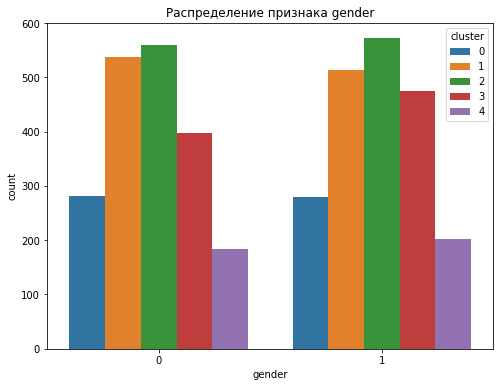

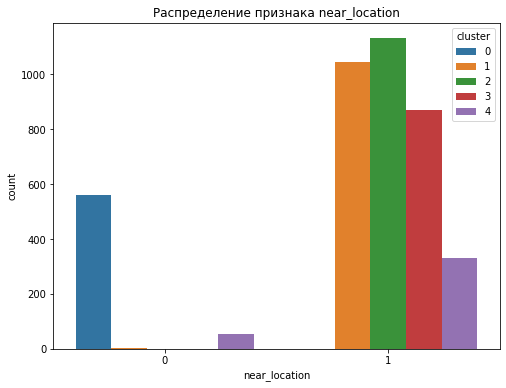

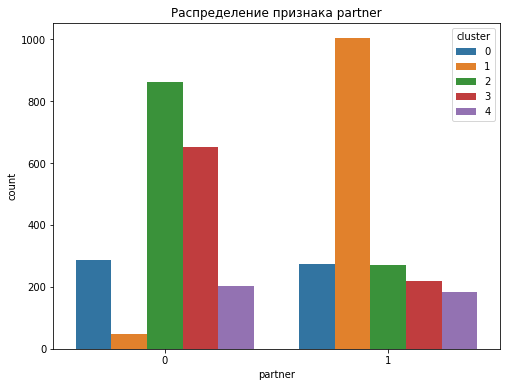

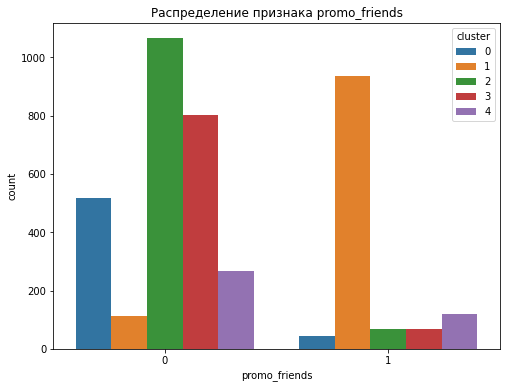

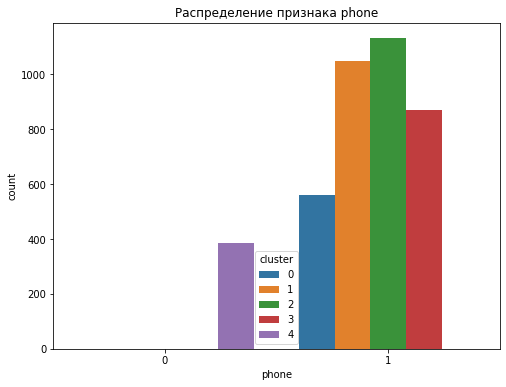

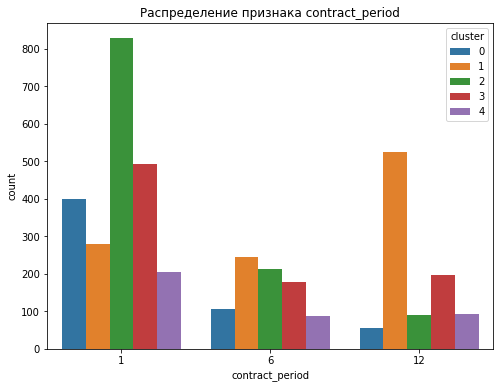

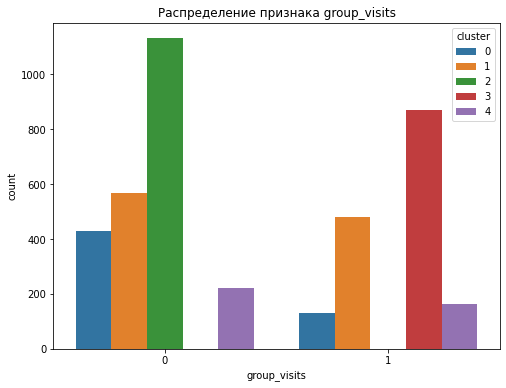

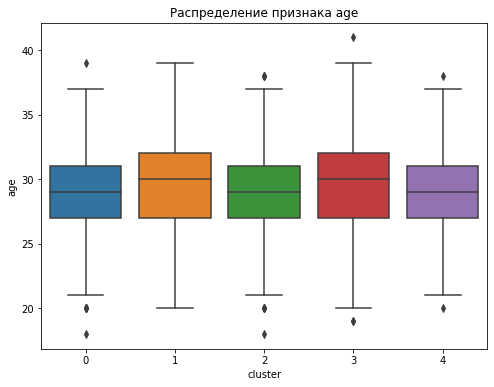

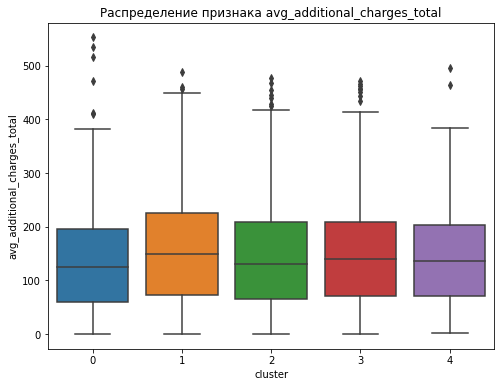

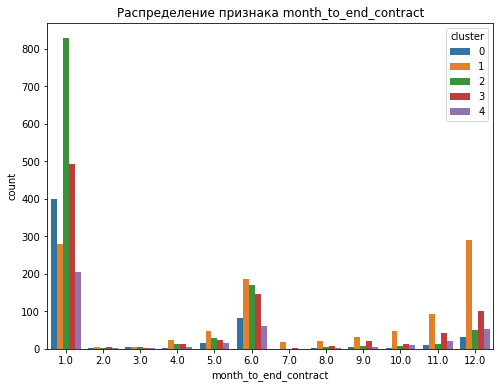

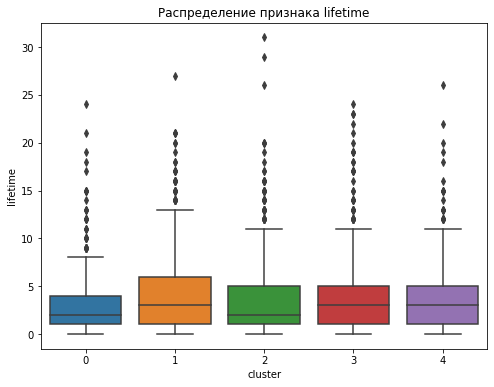

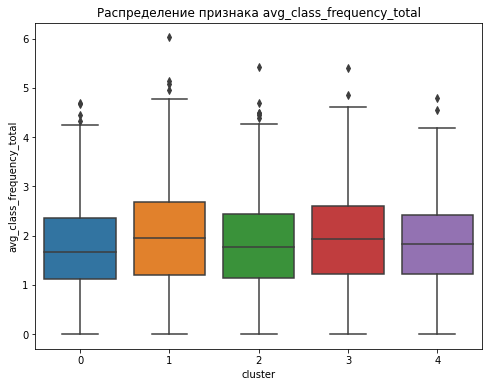

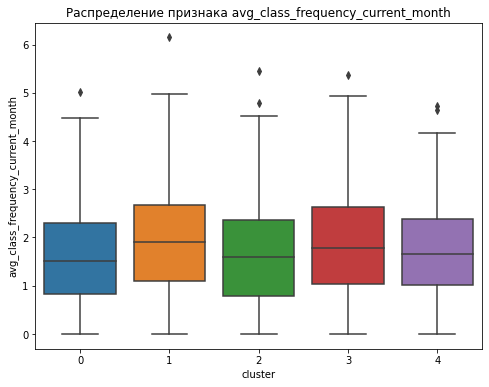

In [22]:
boxplot = [
    'churn', 
    'age', 
    'avg_additional_charges_total', 
    'lifetime', 
    'avg_class_frequency_total', 
    'avg_class_frequency_current_month', 'cluster'
]

for column in data.drop(['churn', 'cluster'], axis=1).columns: # распределение признаков
    if column in boxplot:
        plt.figure(figsize=(8,6))
        sns.boxplot(x=data['cluster'], y=data[column])
        plt.title(f'Распределение признака {column}')
        plt.show()
    else:
        plt.figure(figsize=(8,6))
        sns.countplot(data=data, x=column, hue='cluster')
        plt.title(f'Распределение признака {column}')
        plt.show()

Что важно - клиенты, которые уходят, практически не берут длительные абонементы: склонные к оттоку почти всегда покупают абонемент на один месяц, а вот лояльные кластеры - чаще всего на год. Влияние промо-акций очевидно: лояльные клиенты чаще всего приходят через знакомых или по корпоративной программе. Кстати, обе группы, 1 и 4, проживают или работают в районе фитнес-клуба, вот только первые остаются, а вторые - нет.

В случае с 4 кластером неплохо было бы провести параллели с 5 группой: там тоже не распространены промо-участия, но отток в разы меньше. Отличаются показатели средней выручки, длительности абонемента, а еще средний возраст выше. Может, в нее попали более состоятельные посетители?

In [23]:
print('Silhouette_score: {:.2f}'.format(silhouette_score(X_st, labels))) # метрика силуэта

Silhouette_score: 0.14


Значение метрики оказалось не очень высоким, все же границы наших кластеров довольно размыты судя по полученным признакам.

## Выводы и рекомендации

**Подведем итоги.** 

Основной задачей проекта было оценить лояльность клиентов, обучить модель прогнозирования вероятности оттока и провести кластеризацию для формирования основных принципов удержания клиентов. 
1. Модель логистической регрессии показала себя лучше. Ее показатели метрик recall (0.81), f1-score (0,80) оказались выше модели случайного леса.
2. Модель кластеризации выделила 5 основных групп, среди них заметна сегментация клиентов по доле оттока в своей группе. Так, кластер #1 представляет собой неплохой вариант портрета лояльного клиента; чаще всего он работает где-то недалеко и его работодатель является партнером фитнес-клуба, у него длительный абонемент и в среднем он посещает фитнес-клуб два раза в неделю. 
3. Кластер #4, к сожалению, выделилися большой долей оттока клиентов; в этой группе посетители пользуются небольшими по длительности абонементами, редко имеют корпоративные скидки, посещают фитнес-клуб один раз в неделю.
4. Анализ кластеров показал, что для уровня лояльности клиентов большую роль играют акции, например, "Пригласи друга", и корпоративные сотрудничества; больший лайфтайм оказывается у тех, кто имеет скидки на абонемент через работодателя. 
5. Важной частью стратегии удержания будет являться разработка альтернативных промо-акций, например, комплексных наборов абонементов, чтобы стимулировать клиентов ходить чаще и дольше. Возможно, сомневающимся клиентам придется по душе разработка индивидуальных предложений с покупкой выборочно групповых занятий, или свободного посещения (т.е. не все в одном, а этакий "конструктор". Тут все зависит от того, какие услуги предлагает фитнес-клуб).
6. Необходимо глубже проработать анкеты "лояльных" кластеров, в нашем случае первого, для составления более детального портрета пользователя. Все, что уже работает хорошо (в нашем случае - не "в оттоке"), стоит и дальше поддерживать на должном уровне и развивать, а особенно привлечение новых клиентов через условие с приглашением своих знакомых лояльным кластером.